In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, welch
from scipy.integrate import trapezoid
import seaborn as sns
import math as mt

# Configuración general
sns.set_theme(style="darkgrid")
fs = 173.61  # Frecuencia de muestreo en Hz

# Validamos que cumplimos con el Criterio de Nyquist
assert fs >= 2 * 50, "La frecuencia de muestreo debe ser al menos el doble de la frecuencia máxima de interés (50 Hz)"


# Constantes para las etiquetas de etapas
ETAPAS = {
    0: 'Registro sano',
    1: 'Registro interictal',
    2: 'Registro convulsivo'
}

# Función para cargar los datos desde archivo
def cargar_senal(nombre_archivo):
    with open(nombre_archivo, 'r') as f:
        return np.array([float(line.strip()) for line in f if line.strip()])

# Cargar las tres señales
senales = [cargar_senal(f'Signal_{i}.txt') for i in range(1, 4)]
t = np.arange(len(senales[0])) / fs

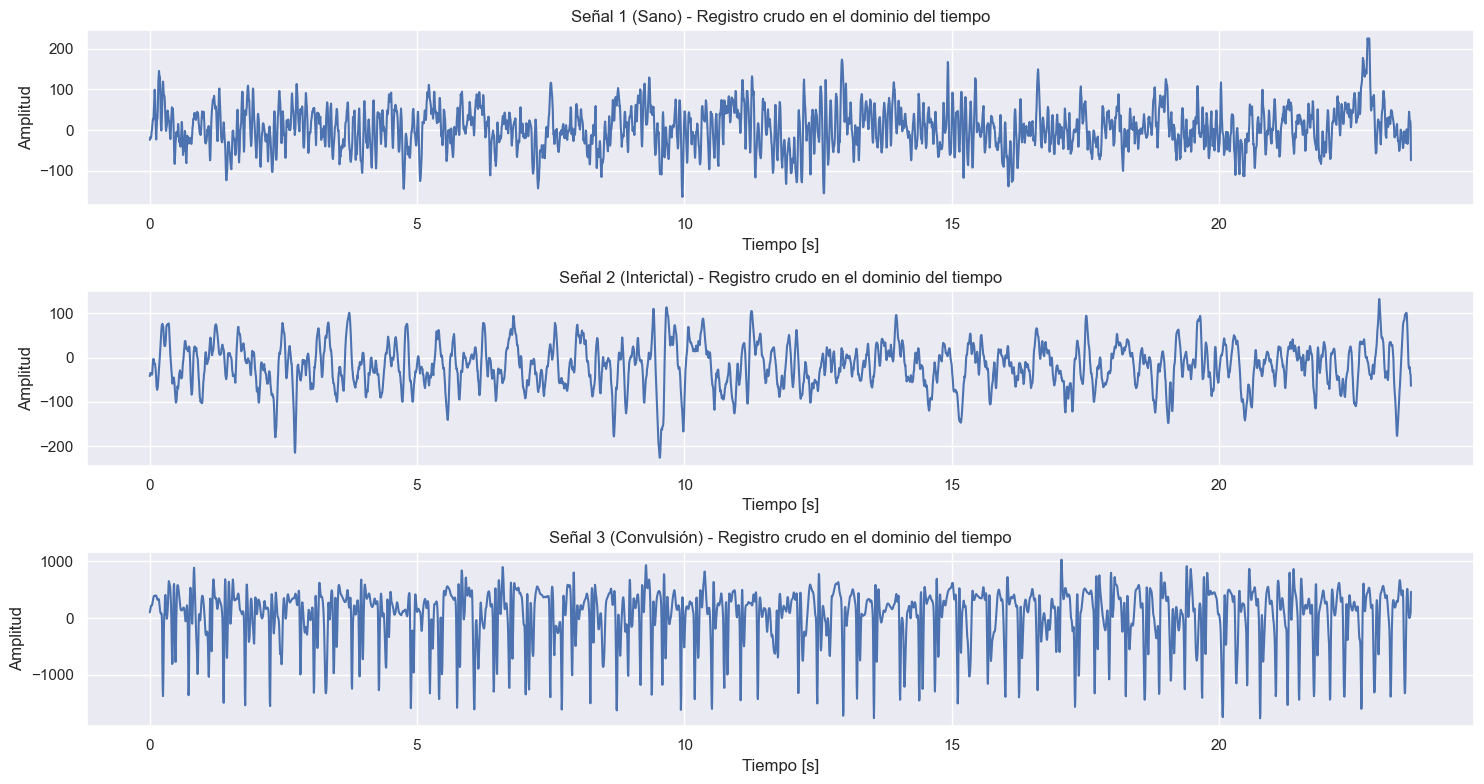

In [5]:
# Función para graficar múltiples señales
def graficar_senales(senales, titulos, xlabel, ylabel, tiempo=None):
    plt.figure(figsize=(15, 8))
    for i, senal in enumerate(senales):
        plt.subplot(3, 1, i + 1)
        x = tiempo if tiempo is not None else np.arange(len(senal))
        plt.plot(x, senal)
        plt.title(titulos[i])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# 1. Visualización en el dominio del tiempo
graficar_senales(
    senales,
    [
        'Señal 1 (Sano) - Registro crudo en el dominio del tiempo',
        'Señal 2 (Interictal) - Registro crudo en el dominio del tiempo',
        'Señal 3 (Convulsión) - Registro crudo en el dominio del tiempo'
    ],
    'Tiempo [s]',
    'Amplitud',
    t
)

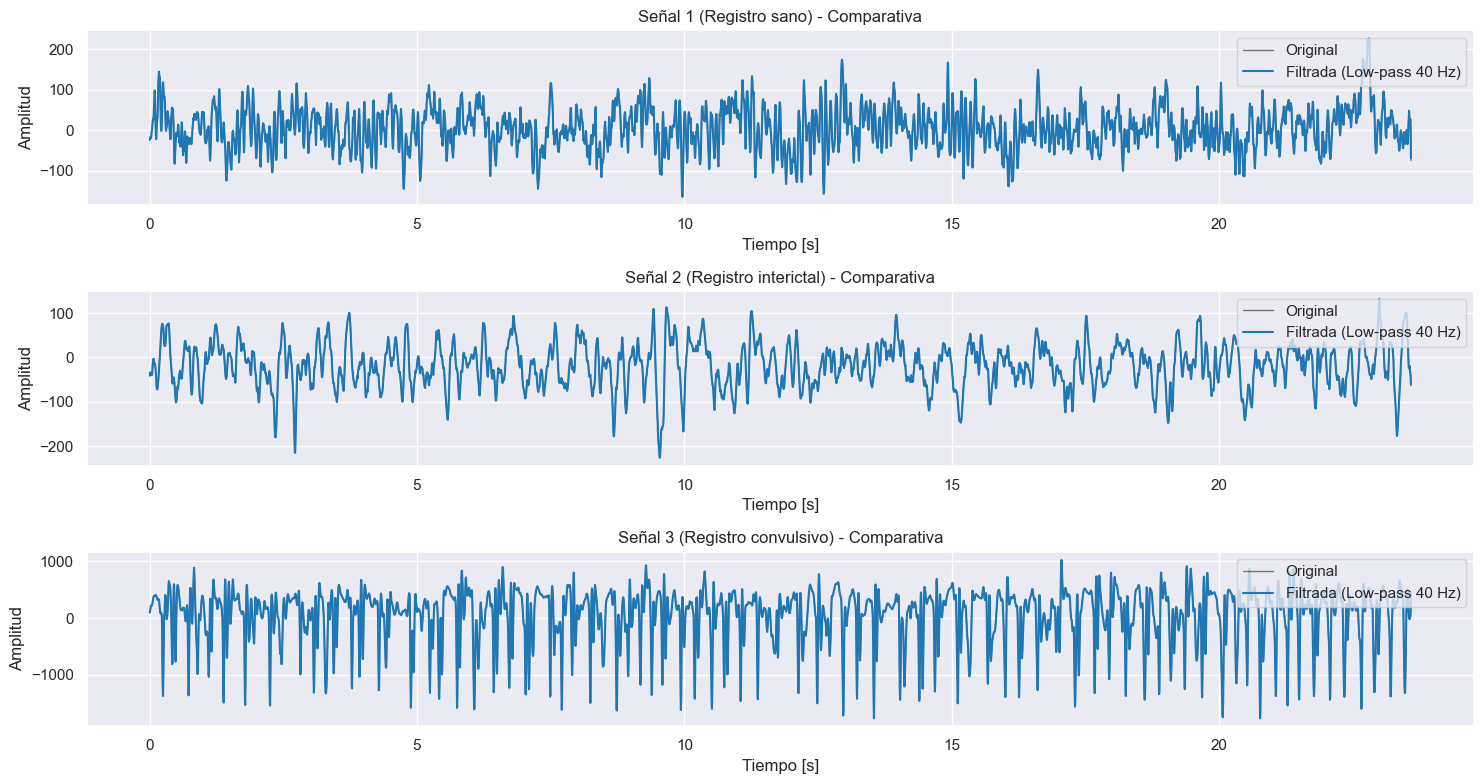

In [6]:
# 2. Filtro pasa bajos
def filtro_pasa_bajos(data, cutoff, fs, num_taps=301):
    """
    Filtro pasa bajos FIR usando ventana de Hamming y convolución.
    
    :param data: señal de entrada.
    :param cutoff: frecuencia de corte en Hz.
    :param fs: frecuencia de muestreo.
    :param num_taps: número de coeficientes (orden del filtro + 1).
    :return: señal filtrada.
    """
    # Normalizar la frecuencia de corte
    fc = cutoff / (fs / 2)
    
    # Crear el filtro FIR con ventana de Hamming
    h = np.sinc(2 * fc * (np.arange(num_taps) - (num_taps - 1) / 2))
    h *= np.hamming(num_taps)
    h /= np.sum(h)  # Normalización para ganancia unitaria
    
    # Aplicar el filtro (modo 'same' mantiene la longitud original)
    filtrada = np.convolve(data, h, mode='same')
    return filtrada

cutoff = 40.0  # Hz
senales_filtradas = [filtro_pasa_bajos(s, cutoff, fs) for s in senales]

# Visualización de señales originales vs filtradas
plt.figure(figsize=(15, 8))
for i in range(3):
    etapa = ETAPAS[i]  
    plt.subplot(3, 1, i + 1)
    plt.plot(t, senales[i], label='Original', color='black', alpha=0.5, linewidth=1.0)
    plt.plot(t, senales_filtradas[i], label=f'Filtrada (Low-pass {mt.ceil(cutoff)} Hz)', color='tab:blue', linewidth=1.5)
    plt.title(f'Señal {i + 1} ({etapa}) - Comparativa')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

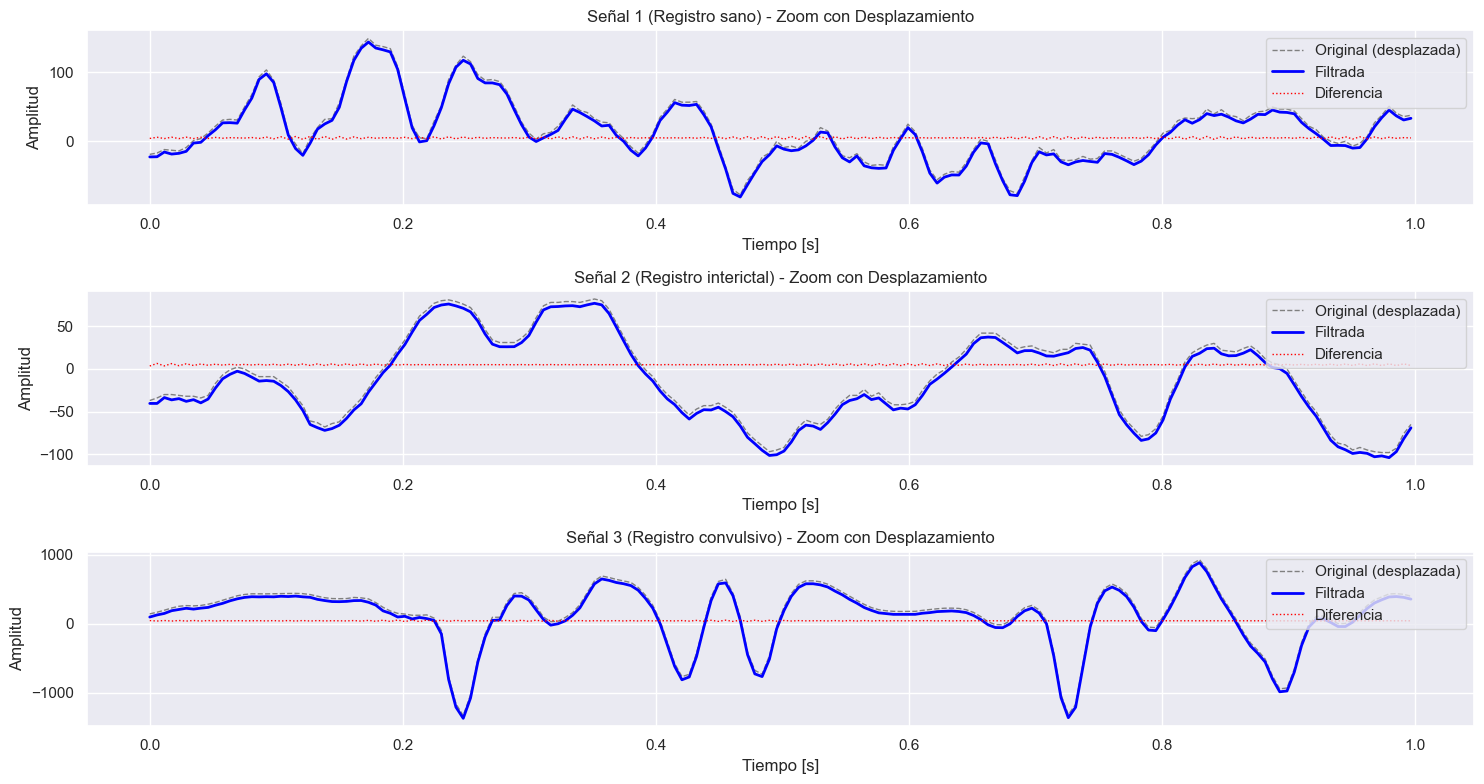

In [7]:
# Ventana temporal más chica (1 segundo sólamente) para ver mejor la diferencia
t_ventana = t[t < 1]
senales_ventana = [s[:len(t_ventana)] for s in senales]
filtradas_ventana = [s[:len(t_ventana)] for s in senales_filtradas]

plt.figure(figsize=(15, 8))
for i in range(3):
    etapa = ETAPAS[i]
    plt.subplot(3, 1, i + 1)

    # Aplicar un pequeño desfase a la original
    desplazamiento = 0.1 * np.std(senales_ventana[i])  # 10% del desvío estándar
    señal_original_desplazada = senales_ventana[i] + desplazamiento

    # Graficar señal original desplazada (gris)
    plt.plot(t_ventana, señal_original_desplazada, label='Original (desplazada)', color='gray', linestyle='--', linewidth=1)

    # Señal filtrada (azul)
    plt.plot(t_ventana, filtradas_ventana[i], label='Filtrada', color='blue', linewidth=2)

    # Diferencia entre ambas
    diferencia = señal_original_desplazada - filtradas_ventana[i]
    plt.plot(t_ventana, diferencia, label='Diferencia', color='red', linestyle=':', linewidth=1)

    plt.title(f'Señal {i + 1} ({etapa}) - Zoom con Desplazamiento')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

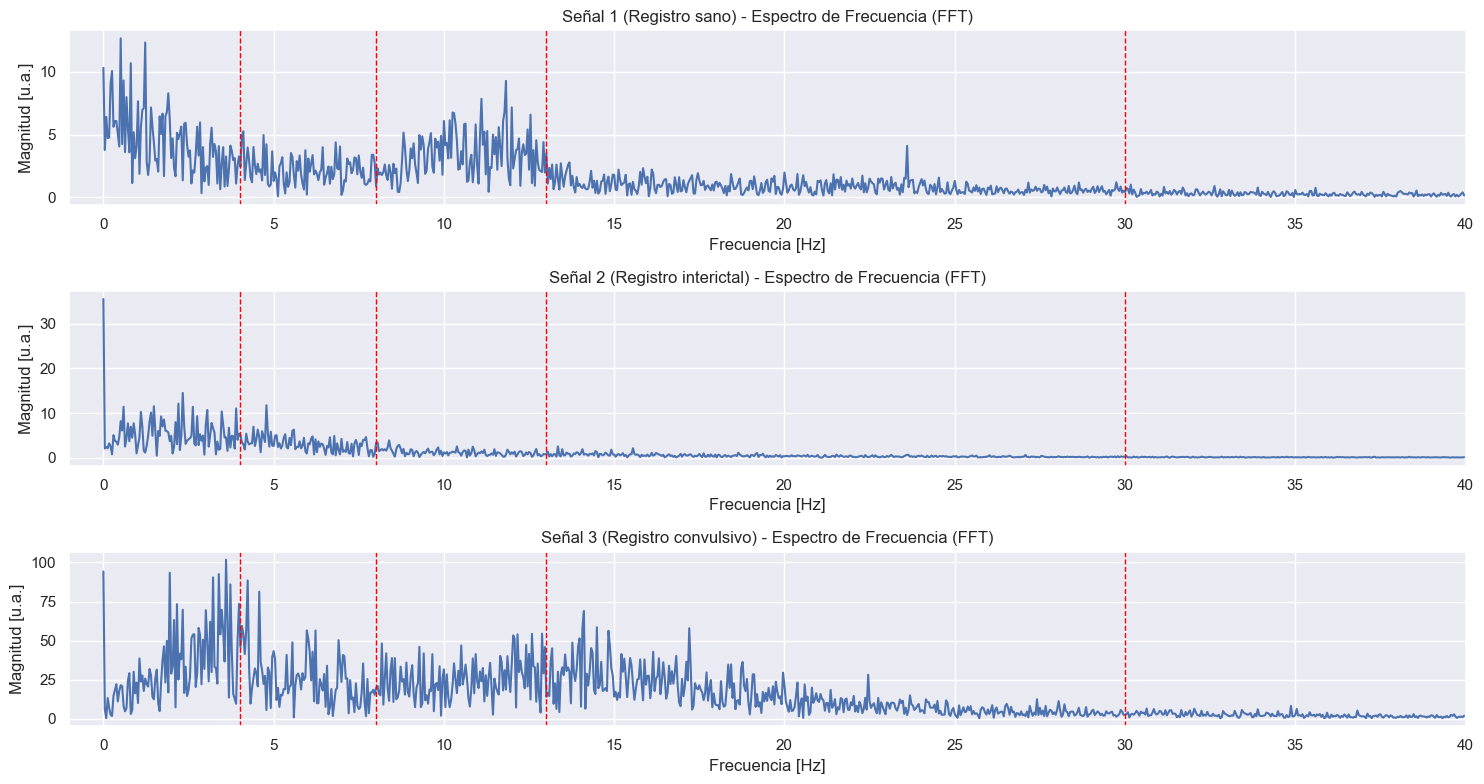

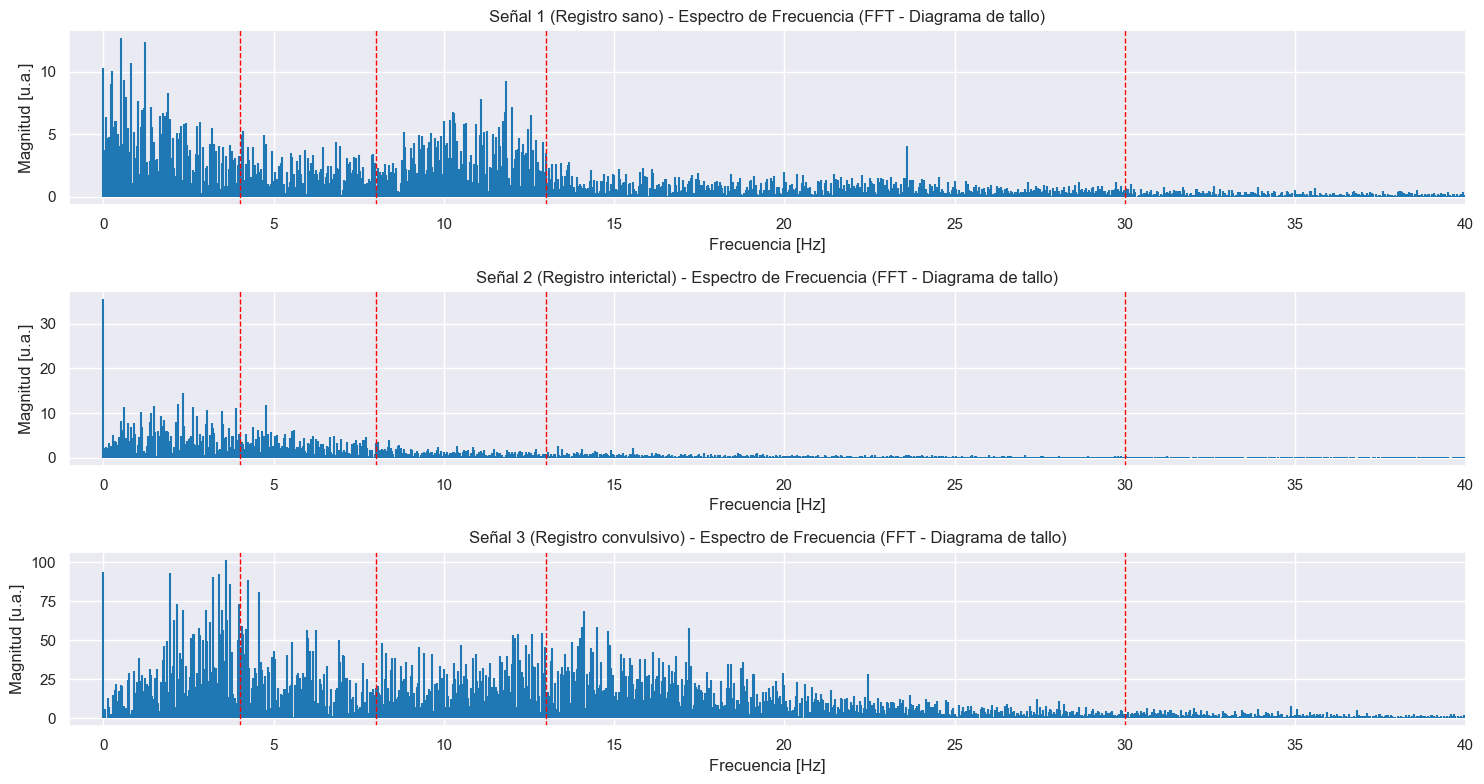

In [8]:
# 3. FFT
def calcular_fft(senal, fs):
    n = len(senal)
    yf = fft(senal)
    xf = fftfreq(n, 1/fs)[:n//2]  # estamos usando la propiedad de simetría de la FFT cortando la señal a la mitad porque la otra mitad es redundante
    return xf, 2.0/n * np.abs(yf[0:n//2]) # devolvemos el módulo, pero lo normalizamos a la mitad porque estamos usando sólo el 50% de la FFT

ffts = [calcular_fft(s, fs) for s in senales_filtradas]

# Frecuencias de corte entre bandas cerebrales
band_limits = [4, 8, 13, 30]

# Visualización de FFT con líneas divisorias
plt.figure(figsize=(15, 8))
for i, (xf, yf) in enumerate(ffts):
    etapa = ETAPAS[i]
    mask = xf <= 40
    plt.subplot(3, 1, i + 1)
    plt.plot(xf[mask], yf[mask])
    plt.title(f'Señal {i + 1} ({etapa}) - Espectro de Frecuencia (FFT)')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud [u.a.]')
    plt.grid(True)
    plt.autoscale(enable=True, axis='y')
    plt.xlim(-1, mt.ceil(cutoff))
    # Líneas verticales en los cortes de banda
    for limit in band_limits:
        plt.axvline(x=limit, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Diagrama de tallo con líneas divisorias
plt.figure(figsize=(15, 8))
for i, (xf, yf) in enumerate(ffts):
    etapa = ETAPAS[i]
    mask = xf <= 40
    plt.subplot(3, 1, i + 1)
    markerline, stemlines, baseline = plt.stem(xf[mask], yf[mask], linefmt='tab:blue', markerfmt=' ', basefmt=' ')
    plt.setp(stemlines, linewidth=1.5)
    plt.title(f'Señal {i + 1} ({etapa}) - Espectro de Frecuencia (FFT - Diagrama de tallo)')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud [u.a.]')
    plt.grid(True)
    plt.autoscale(enable=True, axis='y')
    plt.xlim(-1, mt.ceil(cutoff))
    # Líneas verticales
    for limit in band_limits:
        plt.axvline(x=limit, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

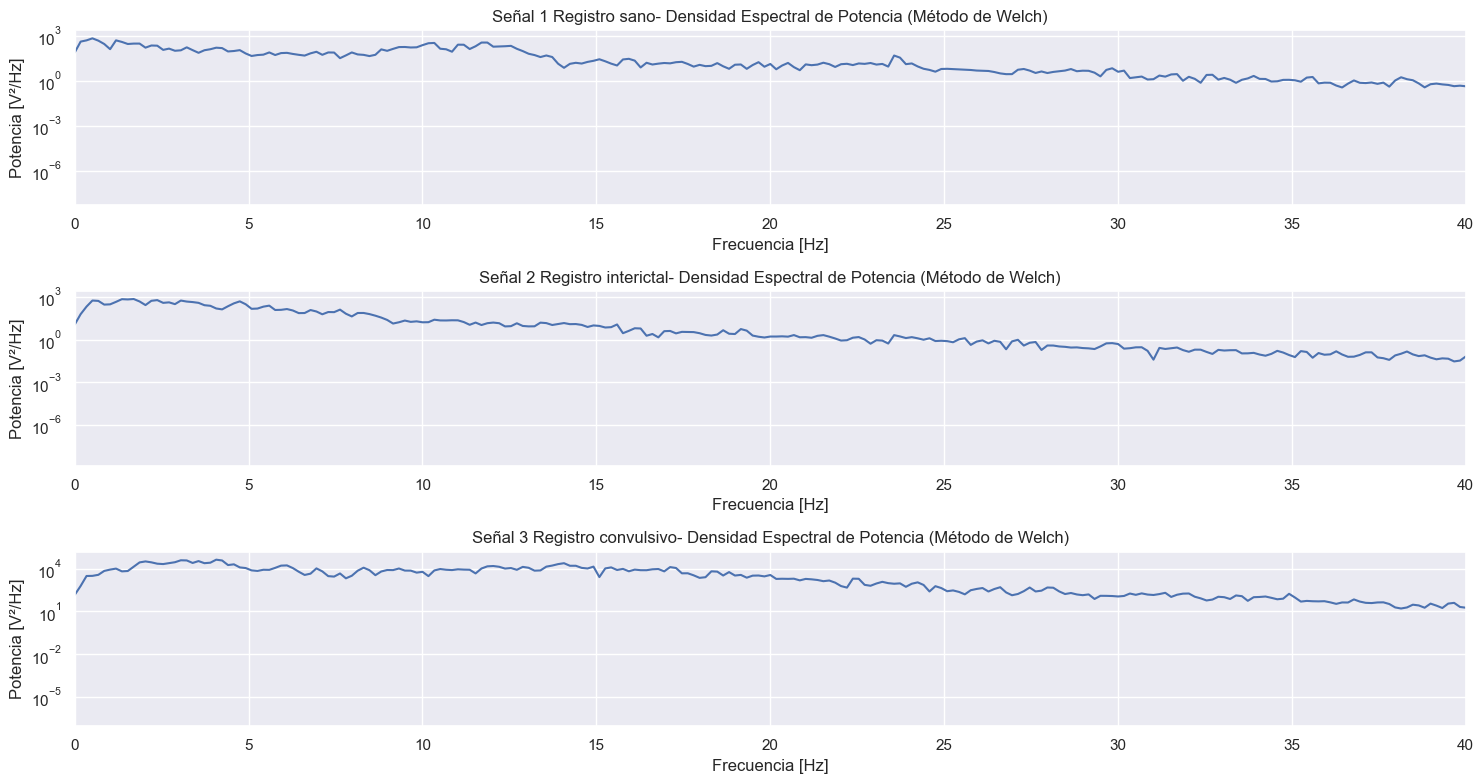

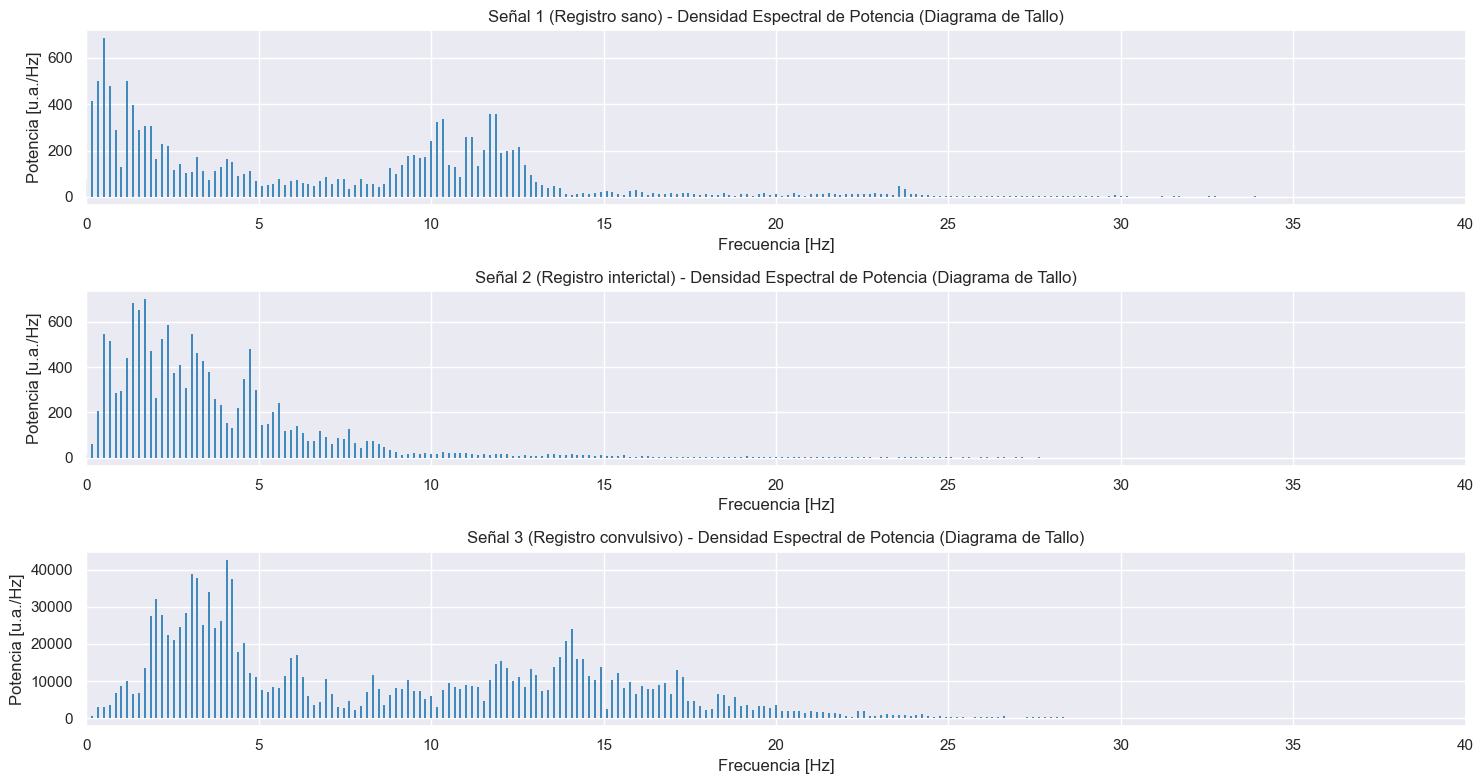

In [9]:
# 4. Potencia espectral (Welch)
def calcular_potencia_espectral(senal, fs):
     f, pxx = welch(senal, fs, nperseg=1024)
     return f, pxx
 
potencias = [calcular_potencia_espectral(s, fs) for s in senales_filtradas]
 
# Visualización de potencia espectral
plt.figure(figsize=(15, 8))
for i, (f, Pxx) in enumerate(potencias):
     etapa = ETAPAS[i]
     plt.subplot(3, 1, i + 1)
     plt.semilogy(f, Pxx)
     plt.title(f'Señal {i + 1} {etapa}- Densidad Espectral de Potencia (Método de Welch)')
     plt.xlabel('Frecuencia [Hz]')
     plt.ylabel('Potencia [V²/Hz]')
     plt.xlim(0, mt.ceil(cutoff))  # Limitar eje X a cutoff
     plt.autoscale(enable=True, axis='y')  # Autoajuste en Y
plt.tight_layout()
plt.show()

# Visualización de potencia espectral (diagrama de tallo) con ejes normales
# Diagrama de tallo de la densidad espectral de potencia (escala lineal)
plt.figure(figsize=(15, 8))
for i, (f, Pxx) in enumerate(potencias):
    etapa = ETAPAS[i]
    plt.subplot(3, 1, i + 1)
    markerline, stemlines, baseline = plt.stem(f, Pxx, linefmt='tab:blue', markerfmt=' ', basefmt=' ')
    plt.setp(stemlines, linewidth=1.2)
    
    plt.title(f'Señal {i + 1} ({etapa}) - Densidad Espectral de Potencia (Diagrama de Tallo)')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia [u.a./Hz]')
    plt.grid(True)
    plt.xlim(0, mt.ceil(cutoff))  # Limitar eje X a cutoff
    plt.autoscale(enable=True, axis='y')  # Autoajuste en Y
plt.tight_layout()
plt.show()

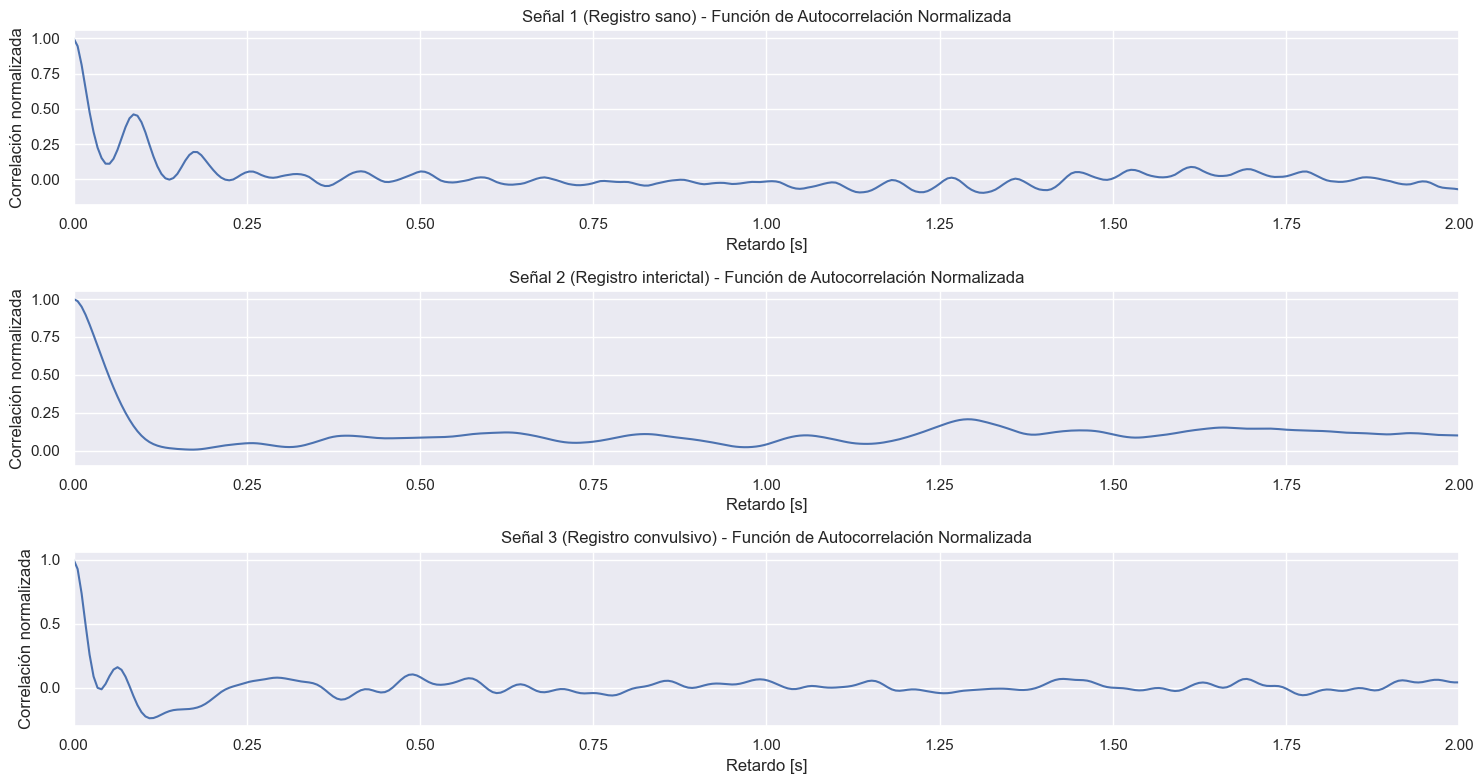

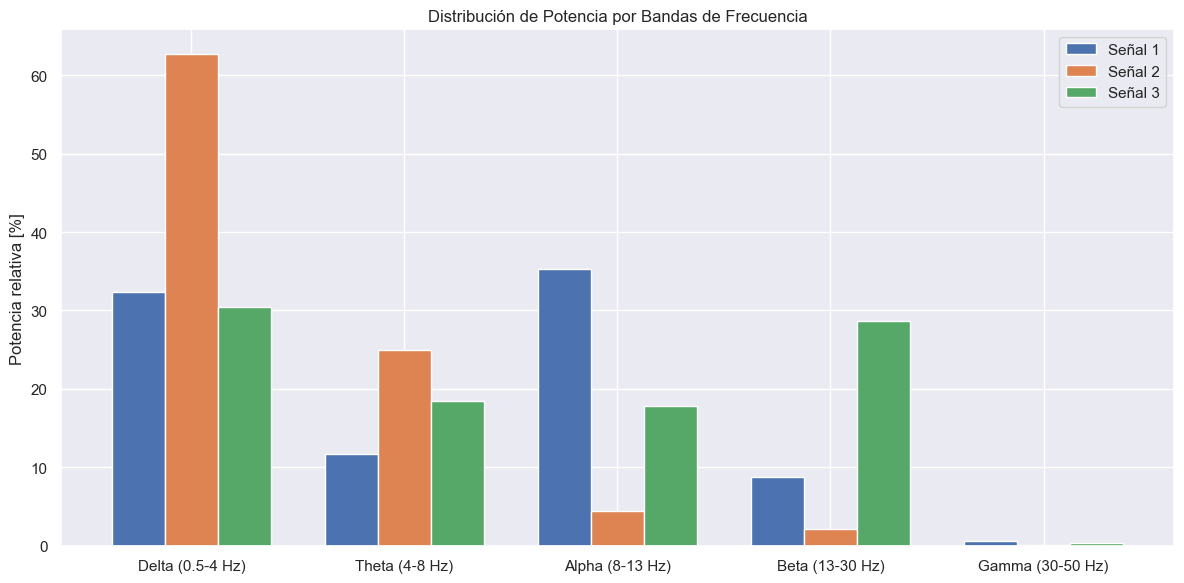

In [10]:
# 5. Autocorrelación
def calcular_autocorrelacion(senal):
    autocorr = np.correlate(senal, senal, mode='full') # calcula la correlación cruzada en todos los lags (positivos y negativos).
    autocorr = autocorr[len(autocorr)//2:] / np.max(autocorr) # cortar a la mitad para quedarnos solo con los desplazamientos positivos (futuro)
                                                              # normalizar para que la autocorrelación máxima (en lag=0) valga 1. Así poder comparar entre señales.
    return autocorr

autocorrelaciones = [calcular_autocorrelacion(s) for s in senales_filtradas]
t_autocorr = np.arange(len(autocorrelaciones[0])) / fs # representa retardos en segundos (lag).

# Visualización de autocorrelación
plt.figure(figsize=(15, 8))
for i, ac in enumerate(autocorrelaciones):
    if i == 0:
        etapa = 'Registro sano'
    elif i == 1:
         etapa = 'Registro interictal'
    else:
        etapa = 'Registro convulsivo'
    plt.subplot(3, 1, i + 1)
    plt.plot(t_autocorr, ac)
    plt.title(f'Señal {i + 1} ({etapa}) - Función de Autocorrelación Normalizada')
    plt.xlabel('Retardo [s]')
    plt.ylabel('Correlación normalizada')
    plt.xlim(0, 2) # limitar la visualización a los primeros 2 segundos
plt.tight_layout()
plt.show()

# 6. Análisis de bandas de frecuencia
def analizar_bandas(f, pxx, nombre_senal, etapa):
    bandas = {
        'Delta (0.5-4 Hz)': (0.5, 4),
        'Theta (4-8 Hz)': (4, 8),
        'Alpha (8-13 Hz)': (8, 13),
        'Beta (13-30 Hz)': (13, 30),
        'Gamma (30-50 Hz)': (30, 50)
    }
    print(f"\n🔍 Análisis de bandas para {nombre_senal} ({etapa}):")
    # print(f"[*] Analisis de bandas para {nombre_senal} ({etapa}):")
    total = trapezoid(Pxx, f)
    for nombre, (low, high) in bandas.items():
        mask = (f >= low) & (f <= high)
        potencia = trapezoid(pxx[mask], f[mask]) # integra el área bajo la curva (PSD) para estimar potencia total y por banda 
        porcentaje = (potencia / total) * 100    # calcular potencia dentro de una banda y su porcentaje respecto al total.
        print(f"{nombre}: {potencia:.4f} ({porcentaje:.2f} % de la potencia total)")
        
# Recolectar potencias por banda para graficar
bandas = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-50 Hz)': (30, 50)
}

nombres_bandas = list(bandas.keys())
potencias_bandas = []

for f, Pxx in potencias:
    total = trapezoid(Pxx, f)
    potencias_por_senal = []
    for low, high in bandas.values():
        mask = (f >= low) & (f <= high)
        potencia = trapezoid(Pxx[mask], f[mask])
        porcentaje = (potencia / total) * 100
        potencias_por_senal.append(porcentaje)
    potencias_bandas.append(potencias_por_senal)

# Convertir a numpy array para graficar fácilmente
potencias_bandas = np.array(potencias_bandas)

# Crear gráfico de bastones
x = np.arange(len(nombres_bandas))  # etiquetas
width = 0.25  # ancho de las barras

plt.figure(figsize=(12, 6))
plt.bar(x - width, potencias_bandas[0], width, label='Señal 1')
plt.bar(x, potencias_bandas[1], width, label='Señal 2')
plt.bar(x + width, potencias_bandas[2], width, label='Señal 3')
plt.xticks(x, nombres_bandas)
plt.ylabel('Potencia relativa [%]')
plt.title('Distribución de Potencia por Bandas de Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
for i, (f, Pxx) in enumerate(potencias):
    etapa = ETAPAS[i]
    analizar_bandas(f, Pxx, f"Señal {i + 1}", etapa)


🔍 Análisis de bandas para Señal 1 (Registro sano):
Delta (0.5-4 Hz): 786.5798 (32.37 % de la potencia total)
Theta (4-8 Hz): 285.1017 (11.73 % de la potencia total)
Alpha (8-13 Hz): 856.2674 (35.23 % de la potencia total)
Beta (13-30 Hz): 213.0051 (8.76 % de la potencia total)
Gamma (30-50 Hz): 14.0885 (0.58 % de la potencia total)

🔍 Análisis de bandas para Señal 2 (Registro interictal):
Delta (0.5-4 Hz): 1519.2596 (62.70 % de la potencia total)
Theta (4-8 Hz): 605.0522 (24.97 % de la potencia total)
Alpha (8-13 Hz): 108.9260 (4.50 % de la potencia total)
Beta (13-30 Hz): 50.7927 (2.10 % de la potencia total)
Gamma (30-50 Hz): 1.6163 (0.07 % de la potencia total)

🔍 Análisis de bandas para Señal 3 (Registro convulsivo):
Delta (0.5-4 Hz): 70235.1233 (30.44 % de la potencia total)
Theta (4-8 Hz): 42741.3645 (18.52 % de la potencia total)
Alpha (8-13 Hz): 41031.2048 (17.78 % de la potencia total)
Beta (13-30 Hz): 66067.1209 (28.63 % de la potencia total)
Gamma (30-50 Hz): 866.6530 (0.38